Image Split (could run but I did not run it in cloud to save time)

In [ ]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):     #I did not run it in cloud, but it could run.
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")

            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands,
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [ ]:
input_file = "./Post_Event_San_Juan.tif"
output_dir = "./Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

In [ ]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))

            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'

            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [ ]:
input_dir = "./Post_Event_Grids_In_TIFF"
output_dir = "./Post_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

In [ ]:
def rename_files(directory_path):
# Define the directory path where your files are located
    directory_path = directory_path

    # Get a list of all files in the directory
    files = os.listdir(directory_path)

    # Define a prefix for the new file names
    # Change the prefix as per requirement
    prefix = "Post_Event_"

    # Start the numbering from 1
    number = 0

    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]

            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"

            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)

            # Rename the file
            os.rename(old_filepath, new_filepath)

            # Increment the number for the next file
            number += 1

    print("Files renamed successfully.")

In [ ]:
rename_files(output_dir)

Data and Model

In [ ]:
!pip install google-cloud-storage

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import storage
import os
import json
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import shutil

# 创建一个客户端以访问您的 Google Cloud Storage
client = storage.Client()

# Define class indexes
class_idx = {
    'undamagedresidentialbuilding': 0,
    'damagedresidentialbuilding': 1,
    'undamagedcommercialbuilding': 2,
    'damagedcommercialbuilding': 3,
}

# Function to download blobs with a specific prefix from the bucket
def download_blobs_with_prefix(bucket_name, prefix, local_dir, delimiter=None):
    """Lists and downloads all the blobs in the bucket that begin with the prefix."""
    bucket = client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix, delimiter=delimiter)

    os.makedirs(local_dir, exist_ok=True)

    for blob in blobs:
        local_path = os.path.join(local_dir, blob.name)
        blob.download_to_filename(local_path)
        print(f'Downloaded {blob.name} to {local_path}')

# Function to process json files and images
def process_files(local_dir):
    json_files = [f for f in os.listdir(local_dir) if f.endswith('.json')]
    for json_file in json_files:
        json_path = os.path.join(local_dir, json_file)
        with open(json_path) as f:
            data = json.load(f)
            df = pd.DataFrame([{
                'label': class_idx[item['label']],
                'x1': item['points'][0][0] / 512,
                'y1': item['points'][0][1] / 512,
                'x2': item['points'][1][0] / 512,
                'y2': item['points'][1][1] / 512
            } for item in data['shapes']])

            txt_name = json_file.rsplit('.', 1)[0]+'.txt'
            df.to_csv(os.path.join(local_dir, txt_name), header=False, index=False, sep=' ')

# Modify these paths to match your bucket structure and local paths
bucket_name = 'final-ruohao'
prefix = 'your_prefix_here'  # e.g., 'data/' if your files are under a "data" directory in the bucket
local_dir = '/tmp/yolo_data'  # Temporary local directory to store downloaded files

download_blobs_with_prefix(bucket_name, prefix, local_dir)
process_files(local_dir)

# Further process steps as necessary, like train/test split...
# Make sure to change directory paths to the correct local_dir paths used above


In [ ]:
from sklearn.model_selection import train_test_split

# 初始化 Google Cloud Storage 客户端
client = storage.Client()

def list_blobs(bucket_name, prefix):
    """列出存储桶中的所有blob"""
    blobs = client.list_blobs(bucket_name, prefix=prefix)
    return blobs

def copy_blob(bucket_name, blob_name, destination_bucket_name, destination_blob_name):
    """复制一个blob到另一个存储桶"""
    source_bucket = client.get_bucket(bucket_name)
    source_blob = source_bucket.blob(blob_name)
    destination_bucket = client.get_bucket(destination_bucket_name)
    source_bucket.copy_blob(source_blob, destination_bucket, destination_blob_name)

source_bucket_name = 'final-ruohao'
destination_bucket_name = 'final-ruohao'  # 使用同一个存储桶

# 假设源文件前缀是
source_prefix = ''

train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
validation_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

# 拷贝文件到新的位置，仅更改前缀
for file in train_files:
    copy_blob(source_bucket_name, file.name, destination_bucket_name, 'train/' + file.name.split('/')[-1])
for file in validation_files:
    copy_blob(source_bucket_name, file.name, destination_bucket_name, 'validation/' + file.name.split('/')[-1])
for file in test_files:
    copy_blob(source_bucket_name, file.name, destination_bucket_name, 'test/' + file.name.split('/')[-1])


In [ ]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 81.5 ms, sys: 7.91 ms, total: 89.4 ms
Wall time: 9.25 s


In [ ]:
!pip install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 738.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.2.1+cu121
    Uninstalling torchaudio-2.2.1+cu121:
      Successfully uninstalled torchaudio-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

In [ ]:
!pip uninstall opencv-python-headless -y

!pip install opencv-python --upgrade

Found existing installation: opencv-python-headless 4.9.0.80
Uninstalling opencv-python-headless-4.9.0.80:
  Successfully uninstalled opencv-python-headless-4.9.0.80
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
import ultralytics
print(ultralytics.__version__)

import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

8.2.2


In [ ]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['undamagedresidentialbuilding', 'damagedresidentialbuilding',
               'undamagedcommercialbuilding', 'damagedcommercialbuilding']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 150 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = 'gs://final-ruohao'  # Google Cloud Storage 中的数据集路径
    OUTPUT_BUCKET_NAME = 'out_put_dir'  # 输出数据的存储桶名称
    OUTPUT_DIR_PREFIX = 'output_dataset/'


In [ ]:
from google.cloud import storage

client = storage.Client()

def upload_yaml_to_gcs(bucket_name, data, destination_blob_name):
    """将YAML数据上传到Google Cloud Storage"""
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    # 将数据转换为YAML格式的字符串
    yaml_str = yaml.dump(data)

    # 上传YAML字符串
    blob.upload_from_string(yaml_str, content_type='application/x-yaml')

    print(f"Uploaded {destination_blob_name} to {bucket_name}")


In [ ]:
dict_file = {
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    # 这里暂时没有包含文件路径，因为我们还没有分配文件到训练、验证、测试集
}

upload_yaml_to_gcs(
    CFG.OUTPUT_BUCKET_NAME,
    dict_file,
    CFG.OUTPUT_DIR_PREFIX + 'data.yaml'  # 指定在输出桶中的位置和文件名
)

Uploaded output_dataset/data.yaml to out_put_dir


In [ ]:
def download_and_read_yaml_from_gcs(bucket_name, source_blob_name):
    """从Google Cloud Storage下载并读取YAML文件"""
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    # 下载YAML文件为字符串
    yaml_str = blob.download_as_string()

    # 转换字符串为数据
    try:
        data = yaml.safe_load(yaml_str)
        return data
    except yaml.YAMLError as e:
        print("Error reading YAML:", e)
        return None

# 下载并打印 YAML 数据
gcs_yaml_path = CFG.OUTPUT_DIR_PREFIX + 'data.yaml'  # 云存储中的完整路径
yaml_data = download_and_read_yaml_from_gcs(CFG.OUTPUT_BUCKET_NAME, gcs_yaml_path)

if yaml_data:
    # 打印数据
    print(yaml.dump(yaml_data, default_flow_style=False))

names:
- undamagedresidentialbuilding
- damagedresidentialbuilding
- undamagedcommercialbuilding
- damagedcommercialbuilding
nc: 4
test: gs://final-ruohao/test
train: gs://final-ruohao/train
val: gs://final-ruohao/validation



In [ ]:
from sklearn.model_selection import train_test_split
import yaml
from google.cloud import storage
import os

client = storage.Client()
bucket_name = 'final-ruohao'

def list_files(bucket_name, suffix):
    bucket = client.get_bucket(bucket_name)
    blobs = bucket.list_blobs()
    return [blob.name for blob in blobs if blob.name.endswith(suffix)]

file_list = list_files(bucket_name, '.jpg')

# 分割文件列表
train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

dict_file = {
    'train': train_files,
    'val': val_files,
    'test': test_files,
    'nc': 4,  # 类别数
    'names': ['undamagedresidentialbuilding', 'damagedresidentialbuilding', 'undamagedcommercialbuilding', 'damagedcommercialbuilding']
}

# 更新并上传 YAML 文件
def upload_yaml_to_gcs(bucket_name, data, destination_blob_name):
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    yaml_str = yaml.dump(data)  # 将数据转换为YAML格式的字符串
    blob.upload_from_string(yaml_str, content_type='application/x-yaml')
    print(f"Uploaded {destination_blob_name} to {bucket_name}")

# 上传新的YAML文件
upload_yaml_to_gcs('out_put_dir', dict_file, 'output_dataset/data.yaml')


Uploaded output_dataset/data.yaml to out_put_dir


In [ ]:

def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties


img_properties = get_image_properties(example_image_path)
print(img_properties)

{'width': 512, 'height': 512, 'channels': 3, 'dtype': dtype('uint8')}


In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = 0, # 0
    verbose = False,
)

100%|██████████| 112M/112M [00:04<00:00, 26.0MB/s]


Ultralytics YOLOv8.1.26 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/content/output_dataset/data.yaml, epochs=150, time=None, patience=20, batch=16, imgsz=(512, 512), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov9e_ppe_css_150_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

100%|██████████| 755k/755k [00:00<00:00, 39.8MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  ultralytics.nn.modules.block.Silence         []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 186MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=512'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/dataset_folder/train/labels... 812 images, 0 backgrounds, 0 corrupt: 100%|██████████| 812/812 [00:00<00:00, 1466.28it/s]

train: New cache created: /content/dataset_folder/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset_folder/validation/labels... 102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<00:00, 622.27it/s]

val: New cache created: /content/dataset_folder/validation/labels.cache


Plotting labels to runs/detect/yolov9e_ppe_css_150_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_150_epochs
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      14.8G      2.304      2.902      2.634        146        512: 100%|██████████| 51/51 [00:34<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        102        473    0.00202      0.133    0.00131   0.000436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      15.2G      2.053      2.747      2.393        166        512: 100%|██████████| 51/51 [00:30<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        102        473    0.00202      0.133    0.00131   0.000436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      14.4G      2.024      2.853      2.388        103        512: 100%|██████████| 51/51 [00:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        102        473   0.000376    0.00918   0.000196   8.45e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      14.4G      1.977      2.841      2.349        101        512: 100%|██████████| 51/51 [00:26<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


                   all        102        473      0.509    0.00589    0.00103   0.000414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      15.2G       1.96       2.85      2.332        172        512: 100%|██████████| 51/51 [00:28<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        102        473    0.00844      0.399     0.0211    0.00707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      15.2G      1.895      2.856       2.28         97        512: 100%|██████████| 51/51 [00:26<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        102        473      0.307    0.00744    0.00524    0.00228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      15.2G      1.901      2.854      2.276        113        512: 100%|██████████| 51/51 [00:26<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        102        473      0.332     0.0832     0.0274    0.00826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      14.4G      1.864       2.81       2.26        164        512: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        102        473      0.257       0.43     0.0275    0.00908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      15.2G      1.841      2.814      2.254        134        512: 100%|██████████| 51/51 [00:26<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        102        473    0.00767      0.441     0.0281    0.00899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      15.2G      1.827      2.792      2.236        141        512: 100%|██████████| 51/51 [00:27<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        102        473      0.255      0.356     0.0162    0.00399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      14.4G      1.796       2.79      2.217        129        512: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        102        473     0.0272      0.285     0.0611     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      14.4G      1.824      2.812      2.241        149        512: 100%|██████████| 51/51 [00:26<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        102        473      0.025      0.471     0.0552     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      15.2G      1.796      2.802      2.213        120        512: 100%|██████████| 51/51 [00:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        102        473      0.256      0.205     0.0124    0.00392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      15.2G      1.782      2.767      2.195        124        512: 100%|██████████| 51/51 [00:27<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        102        473      0.275      0.316     0.0576     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      14.4G       1.78      2.758      2.196        140        512: 100%|██████████| 51/51 [00:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        102        473    0.00975      0.472      0.064     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      14.4G      1.776      2.759        2.2         89        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        102        473    0.00777      0.555     0.0162    0.00558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      15.2G      1.762      2.756       2.17         87        512: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        102        473     0.0139      0.472     0.0521     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      15.2G      1.759      2.758      2.177        145        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        102        473    0.00336       0.23    0.00536    0.00148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      14.4G       1.78      2.765      2.192        173        512: 100%|██████████| 51/51 [00:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        102        473      0.603      0.104     0.0493     0.0175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      14.4G      1.723      2.745      2.154         93        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        102        473      0.589     0.0927     0.0798     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      15.2G       1.74      2.735      2.171        122        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        102        473      0.283      0.389     0.0761     0.0258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      15.2G      1.743      2.731      2.155        113        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        102        473     0.0452      0.774      0.116     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      14.4G       1.76      2.715      2.186        111        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        102        473      0.368      0.133     0.0889     0.0291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      14.4G       1.73      2.725       2.15         91        512: 100%|██████████| 51/51 [00:27<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        102        473     0.0471      0.164     0.0468     0.0185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      15.2G      1.735      2.721      2.162        138        512: 100%|██████████| 51/51 [00:26<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        102        473      0.289      0.193     0.0413     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      15.2G      1.703      2.731      2.143        143        512: 100%|██████████| 51/51 [00:25<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        102        473      0.552      0.292     0.0901     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      14.4G      1.722      2.716      2.137        147        512: 100%|██████████| 51/51 [00:28<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        102        473      0.522      0.427      0.085     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      14.4G      1.728      2.695       2.15        112        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        102        473      0.364      0.159     0.0941     0.0328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      15.2G      1.715      2.728      2.145        114        512: 100%|██████████| 51/51 [00:26<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        102        473      0.275      0.146     0.0284     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      15.2G      1.704      2.732      2.137        170        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        102        473      0.557      0.152     0.0498     0.0183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      15.2G      1.706      2.699      2.128        142        512: 100%|██████████| 51/51 [00:27<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        102        473     0.0134      0.526      0.054     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      14.4G      1.698      2.689      2.136        138        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        102        473      0.309      0.212     0.0531     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      14.4G      1.709      2.729       2.14        123        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        102        473      0.275      0.469     0.0603     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      15.2G      1.699      2.689      2.125        134        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        102        473      0.273      0.433      0.083     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      14.4G      1.701      2.683       2.13        128        512: 100%|██████████| 51/51 [00:25<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        102        473      0.267      0.539      0.125     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      14.4G      1.703      2.698       2.12         98        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        102        473       0.28      0.408     0.0787     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      15.2G      1.691      2.704      2.113         89        512: 100%|██████████| 51/51 [00:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        102        473      0.333      0.203       0.11     0.0393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      15.2G      1.683      2.724      2.107        104        512: 100%|██████████| 51/51 [00:26<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        102        473      0.381      0.148     0.0862     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      14.4G      1.693      2.699      2.125        111        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all        102        473      0.555      0.309     0.0714     0.0281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      15.2G       1.67      2.686      2.121        134        512: 100%|██████████| 51/51 [00:26<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        102        473       0.34      0.168      0.088     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      14.4G      1.655      2.686      2.106         98        512: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        102        473      0.646      0.108        0.1     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      15.2G      1.696      2.693      2.136        104        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        102        473      0.273      0.491      0.115     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      14.4G       1.65      2.653        2.1        180        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        102        473      0.277      0.433     0.0849     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      14.4G      1.655      2.667      2.112        115        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        102        473     0.0977      0.165     0.0991     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      15.2G      1.665      2.675      2.104         95        512: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


                   all        102        473      0.364      0.112      0.108     0.0395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      15.2G      1.652      2.658      2.104         92        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        102        473      0.578      0.231      0.115      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      14.4G       1.66      2.673      2.107        115        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        102        473      0.612      0.132     0.0952     0.0339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      14.4G      1.649      2.667      2.094         91        512: 100%|██████████| 51/51 [00:28<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        102        473      0.333      0.246      0.103     0.0365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      15.2G      1.653      2.686      2.109         75        512: 100%|██████████| 51/51 [00:26<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        102        473      0.664      0.117      0.118     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      15.2G      1.645       2.69      2.105         80        512: 100%|██████████| 51/51 [00:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        102        473      0.372       0.15      0.107     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      14.4G      1.638      2.653      2.102        123        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        102        473      0.564      0.255     0.0852     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      14.4G      1.622      2.648      2.083        110        512: 100%|██████████| 51/51 [00:27<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


                   all        102        473      0.556      0.272     0.0775     0.0287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      15.2G      1.634      2.643       2.09         85        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        102        473      0.313       0.24     0.0863     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      15.2G      1.643      2.659      2.103        142        512: 100%|██████████| 51/51 [00:29<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        102        473      0.605      0.165     0.0969     0.0363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      15.2G      1.638      2.664      2.093         99        512: 100%|██████████| 51/51 [00:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        102        473      0.599      0.172      0.112     0.0429


Stopping training early as no improvement observed in last 20 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

55 epochs completed in 0.550 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_150_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_150_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_150_epochs/weights/best.pt...
Ultralytics YOLOv8.1.26 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
YOLOv9e summary (fused): 687 layers, 57379484 parameters, 0 gradients, 189.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


                   all        102        473      0.267      0.539      0.125     0.0699
Speed: 0.2ms preprocess, 18.6ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_150_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d3eaf1eae90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.26 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
YOLOv9e summary (fused): 687 layers, 57379484 parameters, 0 gradients, 189.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_150_epochs/weights/best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 8, 5376) (111.8 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 63.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.4s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 20.7s, saved as 'runs/detect/yolov9e_ppe_css_150_epochs/weights/best.onnx' (219.2 MB)

Export complete (22.1s)
Results saved to /content/runs/detect/yolov9e_ppe_css_150_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yol

'runs/detect/yolov9e_ppe_css_150_epochs/weights/best.onnx'

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'/content/runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'/content/runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/runs/detect/yolov9e_ppe_css_150_epochs/confusion_matrix.png',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/F1_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/confusion_matrix_normalized.png',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/R_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/results.png',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/PR_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/P_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/labels_correlogram.jpg',
 '/content/runs/detect/yolov9e_ppe_css_150_epochs/labels.jpg']

/content/runs/detect/yolov9e_ppe_css_150_epochs/F1_curve.png


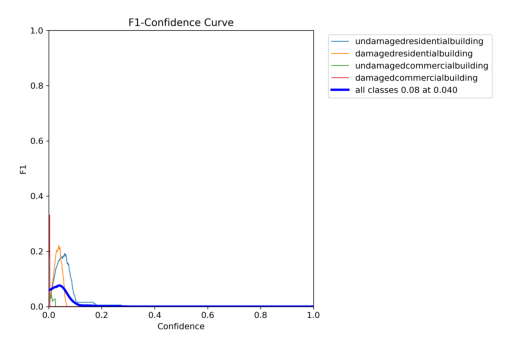



/content/runs/detect/yolov9e_ppe_css_150_epochs/PR_curve.png


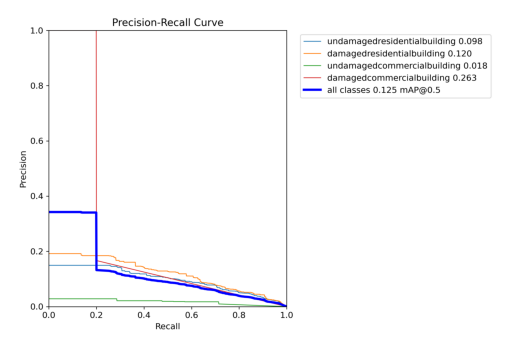



/content/runs/detect/yolov9e_ppe_css_150_epochs/P_curve.png


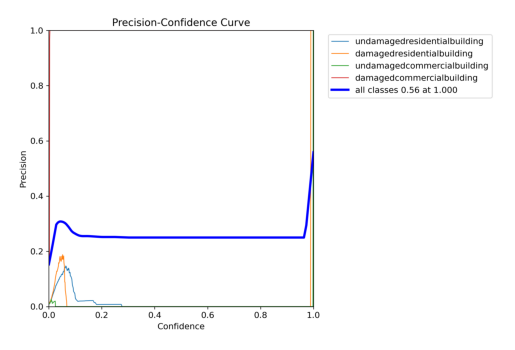



/content/runs/detect/yolov9e_ppe_css_150_epochs/R_curve.png


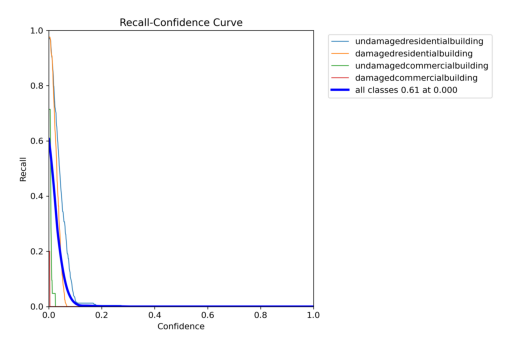



/content/runs/detect/yolov9e_ppe_css_150_epochs/confusion_matrix.png


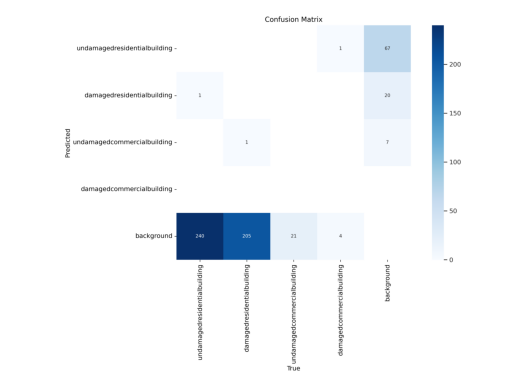



/content/runs/detect/yolov9e_ppe_css_150_epochs/confusion_matrix_normalized.png


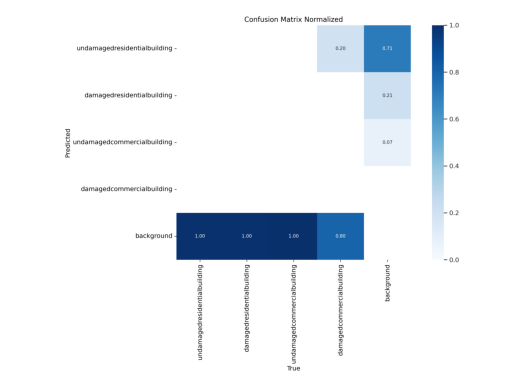



/content/runs/detect/yolov9e_ppe_css_150_epochs/labels.jpg


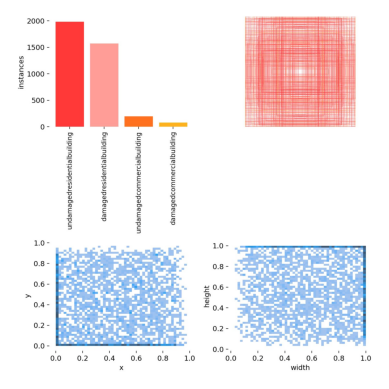



/content/runs/detect/yolov9e_ppe_css_150_epochs/labels_correlogram.jpg


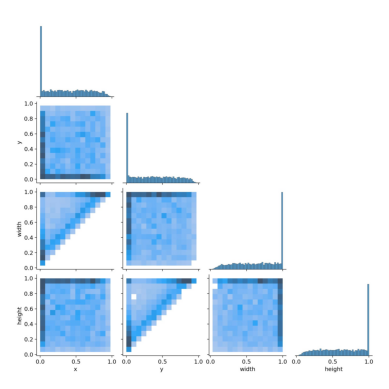



/content/runs/detect/yolov9e_ppe_css_150_epochs/results.png


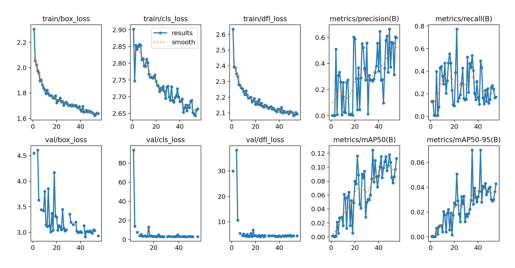

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [ ]:
df = pd.read_csv(f'/content/runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'/content/training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,2.3038,2.9023,2.6336,0.00202,0.13281,0.00131,0.00044,4.5447,inf,30,0.000409,0.000409,0.000409
1,2,2.0534,2.7471,2.3927,0.00202,0.13281,0.00131,0.00044,nan,nan,nan,0.000820,0.000820,0.000820
2,3,2.0239,2.8535,2.3883,0.00038,0.00918,0.00020,0.00008,nan,nan,nan,0.001225,0.001225,0.001225
3,4,1.9766,2.8415,2.3491,0.50873,0.00589,0.00103,0.00041,4.6072,93.622,38.244,0.001225,0.001225,0.001225
4,5,1.9597,2.8500,2.3320,0.00844,0.39869,0.02111,0.00707,3.6284,13.794,10.584,0.001225,0.001225,0.001225
5,6,1.8945,2.8564,2.2803,0.30697,0.00744,0.00524,0.00228,nan,nan,nan,0.001217,0.001217,0.001217
6,7,1.9012,2.8538,2.2757,0.33245,0.08316,0.02745,0.00826,3.4424,7.4832,5.4185,0.001209,0.001209,0.001209
7,8,1.8642,2.8099,2.2602,0.25748,0.42954,0.02752,0.00908,nan,nan,nan,0.001200,0.001200,0.001200
8,9,1.8411,2.8141,2.2538,0.00767,0.44150,0.02809,0.00899,3.4235,3.8906,4.5419,0.001192,0.001192,0.001192
9,10,1.8265,2.7919,2.2364,0.25545,0.35594,0.01619,0.00399,3.8016,5.2503,5.1728,0.001184,0.001184,0.001184


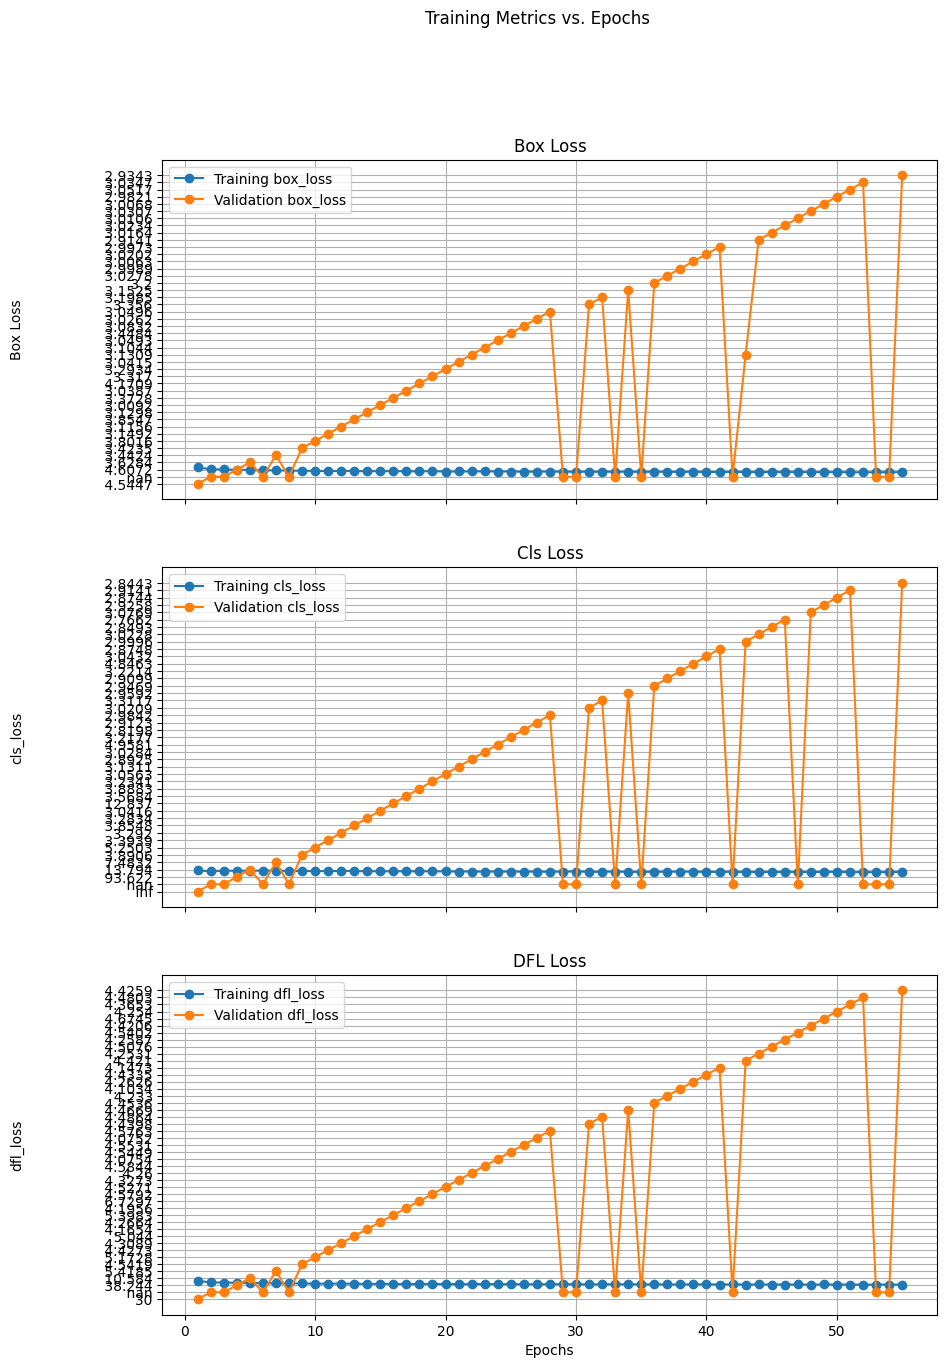

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation Box Loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [ ]:
directory = 'gs://final-ruohao/output_dir data'
# Directory to store outputs
results_directory = 'gs://final-ruohao/output_dir/Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

decoding_of_predictions =class_idx = {
    'undamagedresidentialbuilding': 0,
    'damagedresidentialbuilding': 1,
    'undamagedcommercialbuilding': 2,
    'damagedcommercialbuilding': 3,

}
# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)

        for r in results:
            conf_list = r.boxes.conf.cpu().numpy().tolist()
            clss_list = r.boxes.cls.cpu().numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.boxes.xyxy.cpu().numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")

/content/drive/MyDrive/Submission data/Validation_Post_Event_011.jpg
Making a prediction on  Validation_Post_Event_011.jpg
Results saved to runs/detect/yolov9e_ppe_css_150_epochs
0 label saved to runs/detect/yolov9e_ppe_css_150_epochs/labels
Output files generated successfully.
/content/drive/MyDrive/Submission data/Validation_Post_Event_012.jpg
Making a prediction on  Validation_Post_Event_012.jpg
Results saved to runs/detect/yolov9e_ppe_css_150_epochs
0 label saved to runs/detect/yolov9e_ppe_css_150_epochs/labels
Output files generated successfully.
/content/drive/MyDrive/Submission data/Validation_Post_Event_010.jpg
Making a prediction on  Validation_Post_Event_010.jpg
Results saved to runs/detect/yolov9e_ppe_css_150_epochs
0 label saved to runs/detect/yolov9e_ppe_css_150_epochs/labels
Output files generated successfully.
/content/drive/MyDrive/Submission data/Validation_Post_Event_005.jpg
Making a prediction on  Validation_Post_Event_005.jpg
Results saved to runs/detect/yolov9e_ppe